
# 台灣電力資料 Notebook 報告

此筆記本直接讀取 `data/` 內的公開資料，產生主要圖表並搭配解讀，覆蓋 target.txt 需求中的前幾個主題。其餘主題請參考 `codebook/十主題分析.md` 的文字整理。


In [ ]:

from collections import defaultdict
from pathlib import Path
import csv
import datetime as dt

DATA_DIR = Path('data')


COLORS = [
    '#005c99', '#ef6c00', '#c2185b', '#009688', '#8bc34a', '#ffb300', '#6d4c41', '#512da8'
]

def svg_line_chart(x_labels, series_list, series_labels, title, y_label):
    import datetime as dt
    width, height, margin = 920, 460, 70
    plot_width = width - 2 * margin
    plot_height = height - 2 * margin
    values = [val for series in series_list for val in series]
    min_val = min(values)
    max_val = max(values)
    if min_val == max_val:
        min_val -= 1
        max_val += 1
    y_range = max_val - min_val

    def x_pos(index):
        ratio = 0 if len(x_labels) == 1 else index / (len(x_labels) - 1)
        return margin + ratio * plot_width

    def y_pos(value):
        return height - margin - ((value - min_val) / y_range) * plot_height

    def format_label(label):
        if isinstance(label, dt.date):
            return label.strftime('%Y-%m')
        return str(label)

    label_strings = [format_label(label) for label in x_labels]
    svg_parts = [
        f'<svg xmlns="http://www.w3.org/2000/svg" width="{width}" height="{height}">',
        f'<rect x="0" y="0" width="{width}" height="{height}" fill="white" stroke="#d0d0d0"/>',
        f'<text x="{width/2}" y="30" text-anchor="middle" font-size="20" font-weight="bold">{title}</text>',
        f'<text x="20" y="{height/2}" transform="rotate(-90 20 {height/2})" text-anchor="middle" font-size="12">{y_label}</text>',
        f'<line x1="{margin}" y1="{margin}" x2="{margin}" y2="{height - margin}" stroke="#333"/>',
        f'<line x1="{margin}" y1="{height - margin}" x2="{width - margin}" y2="{height - margin}" stroke="#333"/>'
    ]

    for i in range(5):
        value = min_val + y_range * i / 4
        y = y_pos(value)
        svg_parts.append(f'<line x1="{margin}" y1="{y}" x2="{width - margin}" y2="{y}" stroke="#ececec"/>')
        svg_parts.append(f'<text x="{margin - 10}" y="{y + 4}" text-anchor="end" font-size="10">{value:.1f}</text>')

    x_positions = [x_pos(i) for i in range(len(x_labels))]
    step = max(1, len(x_labels) // 10)
    for idx, (x, label) in enumerate(zip(x_positions, label_strings)):
        if idx % step == 0 or idx == len(x_labels) - 1:
            svg_parts.append(
                f'<text x="{x}" y="{height - margin + 35}" transform="rotate(45 {x} {height - margin + 35})" font-size="10" text-anchor="start">{label}</text>'
            )

    for s_idx, values in enumerate(series_list):
        color = COLORS[s_idx % len(COLORS)]
        points = ' '.join(f'{x_positions[i]},{y_pos(val)}' for i, val in enumerate(values))
        svg_parts.append(f'<polyline fill="none" stroke="{color}" stroke-width="2" points="{points}"/>')
        for i, val in enumerate(values):
            svg_parts.append(f'<circle cx="{x_positions[i]}" cy="{y_pos(val)}" r="2.5" fill="{color}"/>')

    legend_cols = 4
    legend_dx = 160
    legend_dy = 18
    for idx, label in enumerate(series_labels):
        row = idx // legend_cols
        col = idx % legend_cols
        lx = margin + col * legend_dx
        ly = margin - 35 + row * legend_dy
        color = COLORS[idx % len(COLORS)]
        svg_parts.append(f'<rect x="{lx}" y="{ly}" width="14" height="14" fill="{color}"/>')
        svg_parts.append(f'<text x="{lx + 18}" y="{ly + 12}" font-size="11">{label}</text>')

    svg_parts.append('</svg>')
    return '
'.join(svg_parts)


def load_energy_mix():
    from collections import defaultdict
    import csv
    path = Path('data') / '發購電量(能源別).csv'
    energy_map = {
        '燃煤': '燃煤','燃氣': '燃氣','燃油': '燃油','核能': '核能','抽蓄水力': '水力/抽蓄','水力': '水力/抽蓄','慣常水力': '水力/抽蓄','承攬水力': '水力/抽蓄','太陽能': '再生能源','風力': '再生能源','生質能': '再生能源','垃圾沼氣': '再生能源','廢棄物': '再生能源','地熱': '再生能源','電池': '再生能源','汽電共生': '汽電共生'
    }
    year_totals = defaultdict(lambda: defaultdict(float))
    groups = set()
    with path.open(encoding='utf-8-sig') as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            year = int(row['年度'])
            value = float(row['發購電量']) if row['發購電量'] else 0.0
            group = energy_map.get(row['能源別'], '其他')
            year_totals[year][group] += value
            groups.add(group)
    years = sorted(year_totals)
    last_year = years[-1]
    group_order = sorted(groups, key=lambda g: year_totals[last_year].get(g, 0.0), reverse=True)
    series = {group: [year_totals[year].get(group, 0.0) / 1e9 for year in years] for group in group_order}
    return years, group_order, series


def load_sales_by_use():
    from collections import defaultdict
    import csv
    path = Path('data') / '售電量(用途別).csv'
    usage_totals = defaultdict(lambda: defaultdict(float))
    years = set()
    with path.open(encoding='utf-8-sig') as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            year = int(row['年度'])
            usage = row['用途別']
            value = float(row['售電量']) if row['售電量'] else 0.0
            usage_totals[usage][year] = value / 1e9
            years.add(year)
    years = sorted(years)
    order = ['工業售電量', '住宅售電量', '商業售電量', '其他售電量']
    series = {usage: [usage_totals[usage].get(year, 0.0) for year in years] for usage in order}
    return years, order, series


def load_monthly_reserve():
    from collections import defaultdict
    import csv, datetime as dt
    path = Path('data') / '近三年每日尖峰備轉容量率.csv'
    buckets = defaultdict(list)
    with path.open(encoding='utf-8-sig') as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            if not row['備轉容量率(%)']:
                continue
            date = dt.datetime.strptime(row['日期'], '%Y%m%d')
            key = dt.date(date.year, date.month, 1)
            buckets[key].append(float(row['備轉容量率(%)']))
    months = sorted(buckets)
    averages = [sum(buckets[m]) / len(buckets[m]) for m in months]
    return months, averages



## 1. 台灣能源結構變化

以下圖表顯示 2004–2024 年燃煤、燃氣、核能、再生能源等類別的發購電量。單位為 TWh。


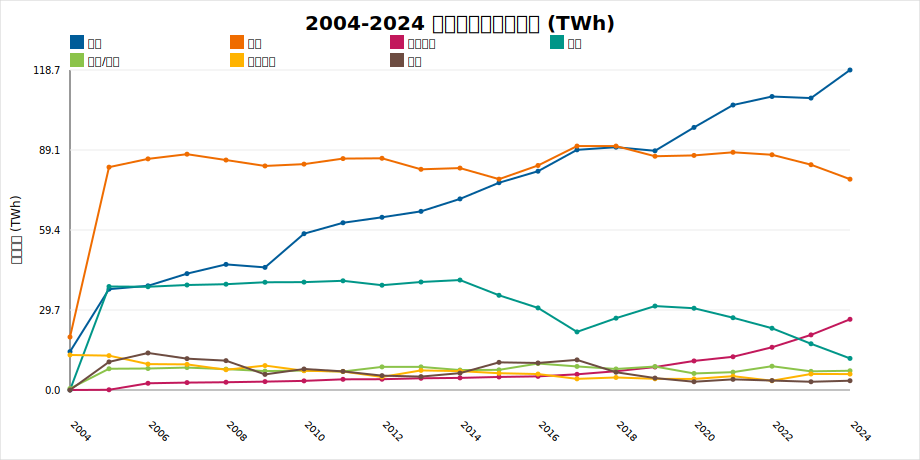

In [2]:

years_energy, energy_groups, energy_series = load_energy_mix()
energy_mix_svg = svg_line_chart(
    years_energy,
    [energy_series[group] for group in energy_groups],
    energy_groups,
    '2004-2024 年發購電量能源結構 (TWh)',
    '發購電量 (TWh)'
)
energy_mix_svg



- **2024 年發購電量主力**：燃氣 118.7 TWh、燃煤 78.2 TWh，
  再生能源達 26.2 TWh，十年來快速成長。
- 燃油與汽電共生僅少量出力，顯示燃氣/燃煤仍是尖峰調度重點。



## 2. 台灣電力需求結構（用途別）

`售電量(用途別).csv` 提供 2004–2024 年住宅、工業、商業、其他售電量。下圖展示各用途的長期趨勢。


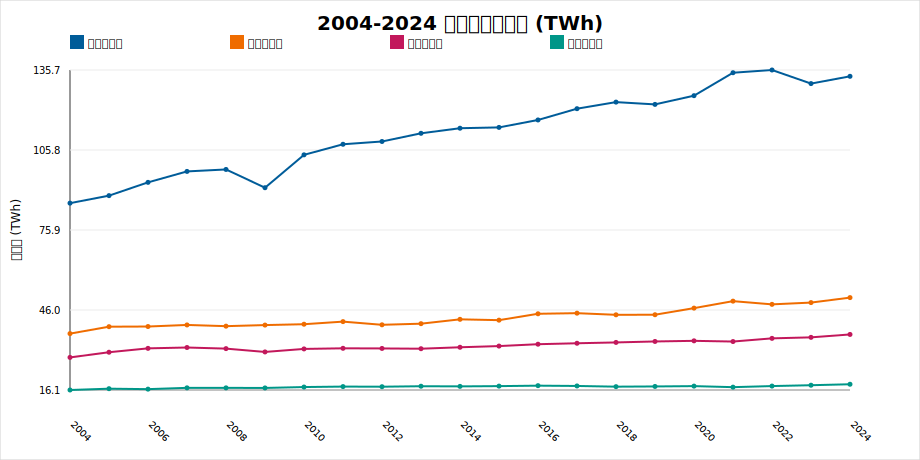

In [3]:

years_usage, usage_order, usage_series = load_sales_by_use()
usage_svg = svg_line_chart(
    years_usage,
    [usage_series[label] for label in usage_order],
    usage_order,
    '2004-2024 年用途別售電量 (TWh)',
    '售電量 (TWh)'
)
usage_svg


- **工業售電量**：133.3 TWh（2024 年）
- **住宅售電量**：50.6 TWh（2024 年）
- **商業售電量**：36.9 TWh（2024 年）
- **其他售電量**：18.2 TWh（2024 年）
- 工業用電長期維持整體用電約半數以上，是評估景氣的最佳代理。
- 住宅/商業用電在疫情後的高檔水準與高溫氣候高度連動。


## 3. 電力供需平衡（備轉容量率）

利用 `近三年每日尖峰備轉容量率.csv` 計算每月平均備轉容量率，可觀察季節性與極端天氣對供電安全的影響。


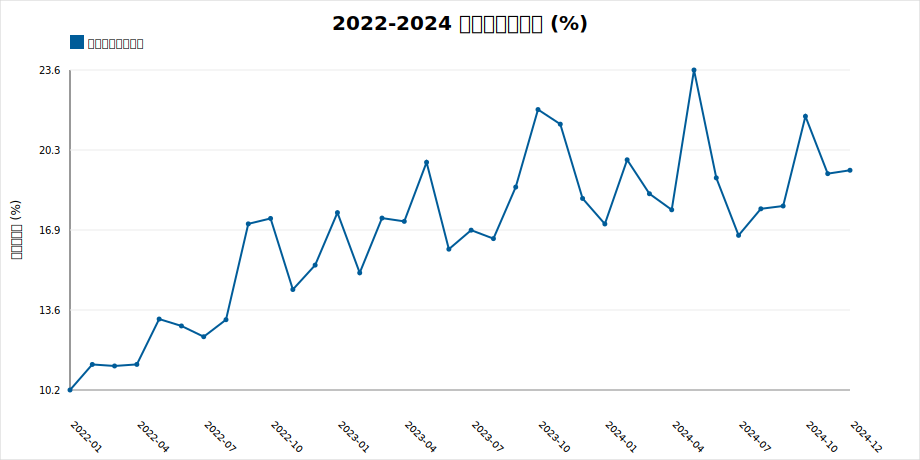

In [4]:

months_reserve, reserve_avg = load_monthly_reserve()
reserve_svg = svg_line_chart(
    months_reserve,
    [reserve_avg],
    ['備轉容量率月均值'],
    '2022-2024 月均備轉容量率 (%)',
    '備轉容量率 (%)'
)
reserve_svg



- **最低月均備轉**：2022-01 僅 10.25% ，聚焦在 2022 年初寒流期間。
- **最高月均備轉**：2024-05 達 23.64% ，顯示 2024 年 5 月水力與燃氣供應充裕。
- 觀察趨勢線可見備轉率旺季落差約 10 個百分點，適合納入需求面管理策略。



## 4. 後續分析建議

- 其餘主題（再生能源成效、發電成本、排放等）已整理於 `codebook/十主題分析.md`。
- 若需互動式儀表板，可將本筆記本的原始 CSV 轉為資料倉儲，再匯入 Power BI 或 Tableau。
